In [1]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import pandas as pd
from tqdm.notebook import tqdm
import pickle
import requests
import re
import numpy as np
from transformers import pipeline
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
classifier = pipeline("text-classification",model='bhadresh-savani/bert-base-uncased-emotion', return_all_scores=True)
from afinn import Afinn
from collections import defaultdict
sent_lexicon = defaultdict(lambda: 0, Afinn()._dict)


C:\Users\Yucheng\anaconda3\lib\site-packages\transformers\pipelines\text_classification.py:89: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [2]:
with open('df_text.pickle', 'rb') as handle:
    df_text = pickle.load(handle)

In [3]:
quotes_dict = {}
exception_list = []

for name in tqdm(list(df_text['Name'])):
    try:
        url = "https://wowpedia.fandom.com/wiki/{}".format(name)
        html = urlopen(url).read()
        soup = BeautifulSoup(html, features="html.parser")

        quotes = []
        sentiment_dict = {}

        target = soup.find('h2',text='Quotes') if soup.find('h2',text='Quotes') else soup.find('h2',text='Memorable quotes')


        for sib in target.find_next_siblings():
            if sib.name == "h2":
                break
            else:
                if sib.name == 'ul' or sib.name == 'li':
                    if ":" not in sib.text:
                        g = [t for t in sib.text.split("\n") if len(t) > 0]
                        for j in g:
                            quotes.append("".join(j))

        quotes_dict[name] = quotes

        #                 if i == 2:
        #                     break
    except AttributeError:
        exception_list.append(name)


In [4]:
quotes_dict['Malfurion_Stormrage']

['"You\'ll find us a sour treat." (Malfurion\'s answer to Sargeras\' threat that he will devour all of Azeroth.)',
 '"You want power? Feel the power of the world you would betray, captain!"',
 '"For you, there is only the Well and the supposed might of a demon that claims godhood. For me--there\'s the power of the world itself as my ally."',
 '"You have betrayed too many, you have hurt too many, lord advisor. I won\'t let you hurt anyone, anymore. From you there will only come life from now on, not death."',
 '"Hush Tyrande! Where is Illidan?',
 '"Illidan, the Well is out of control!',
 '"Not if we are caught up in it! Why weren\'t you running? What have you\'ve been doing with your hand in the Well, Illidan?',
 '"The horn has sounded, and I have come as promised. I smell the stench of decay and corruption in our land. That angers me greatly."',
 '"Oh, no. How could I have forgotten? This door leads to Illidan\'s prison, Tyrande. We should go... now!"',
 '"That beast must never be set 

In [5]:
emotions = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
emotion_dict = {key: 0 for key in emotions}

quotes = quotes_dict['Malfurion_Stormrage']

for q in quotes:
    prediction = classifier(q)[0]
    prediction = [list(i.items()) for i in prediction]
    
    emo = sorted(prediction, key=lambda x:x[1], reverse=True)[0][0][1]
    emotion_dict[emo] += 1 

print(emotion_dict)

{'sadness': 0, 'joy': 12, 'love': 0, 'anger': 14, 'fear': 1, 'surprise': 0}


In [6]:
proportions = list([(e / len(quotes)) for e in emotion_dict.values()] ) 

max_new = 1
max_old = 1
min_new = 0.5
min_old = 0
# from https://stats.stackexchange.com/a/286273
proportions2 = [(max_new - min_new) / (max_old - min_old) * ((e / len(quotes)) - max_old) + max_new  for e in emotion_dict.values()]

print(proportions)
print(proportions2)

[0.0, 0.4444444444444444, 0.0, 0.5185185185185185, 0.037037037037037035, 0.0]
[0.5, 0.7222222222222222, 0.5, 0.7592592592592593, 0.5185185185185185, 0.5]


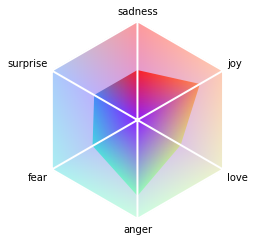

In [7]:
# Adapted from: https://stackoverflow.com/a/65727591

proportions = proportions2
labels = list(emotion_dict.keys())
N = len(proportions2)
proportions = np.append(proportions2, 1)
theta = np.linspace(0, 2 * np.pi, N, endpoint=False)
x = np.append(np.sin(theta), 0)
y = np.append(np.cos(theta), 0)
triangles = [[N, i, (i + 1) % N] for i in range(N)]
triang_backgr = tri.Triangulation(x, y, triangles)
triang_foregr = tri.Triangulation(x * proportions, y * proportions, triangles)
cmap = plt.cm.rainbow_r  # or plt.cm.hsv ?
colors = np.linspace(0, 1, N + 1)
plt.tripcolor(triang_backgr, colors, cmap=cmap, shading='gouraud', alpha=0.4)
plt.tripcolor(triang_foregr, colors, cmap=cmap, shading='gouraud', alpha=0.8)
plt.triplot(triang_backgr, color='white', lw=2)
for label, color, xi, yi in zip(labels, colors, x, y):
    plt.text(xi * 1.05, yi * 1.05, label,  # color=cmap(color),
             ha='left' if xi > 0.1 else 'right' if xi < -0.1 else 'center',
             va='bottom' if yi > 0.1 else 'top' if yi < -0.1 else 'center')
plt.axis('off')
plt.gca().set_aspect('equal')
plt.show()